# Author: Tim Harmling and Alexej Kravtschenko
- **Note:** This notebook was written by the combined effort of Tim Harmling and Alexej Kravtschenko 
- **Description:** Automatic Workflow to Transfer Learn the Handwriting Model

In [1]:
#import handwriting.load_data as load_data
import load_transfer_data
import load_data
import models as models # Use: build_model9v3(img_width, img_height, char) 
import learning_rate_scheduler as lrs
#Imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pathlib
import pickle
import time
import os
import re


2024-05-08 13:41:42.586438: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 13:41:42.593377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 13:41:43.451662: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 13:41:45.301926: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 13:41:55.594248: W tensorflow/compiler/tf2

Maximum length:  29
Vocab size:  66


2024-05-08 13:42:23.136792: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 13:42:27.561867: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 13:42:27.561913: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 13:42:27.563493: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 13:42:27.563531: I external/local_xla/xla/stream_executor

## Config

In [26]:
from config import *

## Load Data

In [4]:
print(f"Training path: {x_train_img_paths[0:2]}", y_train_labels[0:2])
print(f"Validation path: {x_val_img_paths[0:2]}", y_val_labels[0:2])
#print(f"Testing path: {x_test_img_paths[0:2]}", y_test_labels[0:2])

Training path: ['dataset/transfer_dataset/train/10_10.jpg', 'dataset/transfer_dataset/train/10_11.jpg'] ['Fabian', '12A']
Validation path: ['dataset/transfer_dataset/val/0_0.jpg', 'dataset/transfer_dataset/val/0_1.jpg'] ['Lüdtke', 'Markus']


## Create Dataset

In [5]:
# Has to be here because load data functions need to be called before
import tokenizer

train_ds = tokenizer.prepare_dataset(x_train_img_paths, y_train_labels, (IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
aug_train_ds = tokenizer.prepare_augmented_dataset(x_train_img_paths, y_train_labels, BATCH_SIZE)
val_ds = tokenizer.prepare_dataset(x_val_img_paths, y_val_labels,(IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)

## Show Examples

2024-05-08 13:42:31.072016: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


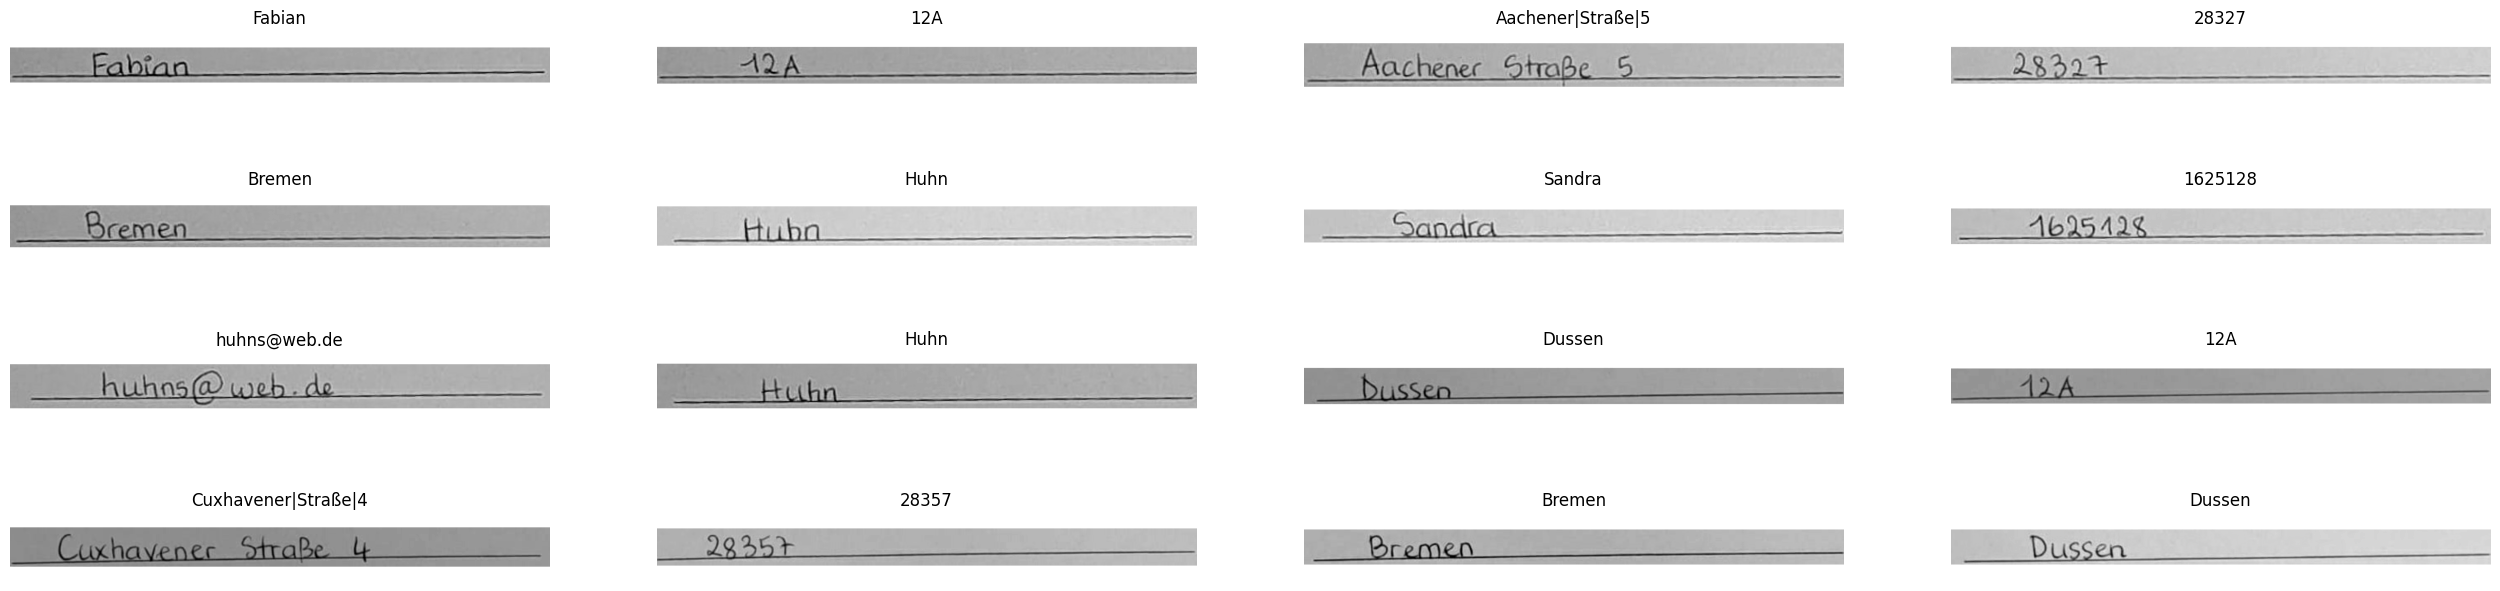

In [6]:
for data in aug_train_ds.take(1):
    images, labels = data["image"], data["label"]

    ax = plt.subplots(4, 4, figsize=(32, 8))[1]

    for i in range(min(16,BATCH_SIZE)):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, tokenizer.padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(tokenizer.num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()  

# Train Keras Model

In [7]:
weights_keras_string ="_weights.keras"

def model_load_weights_if_exists(model):
    """Loads model weights if they exist.

    This function checks if the model weights exist and loads them into the model.

    Args:
        model: The Keras model.

    Returns: 
        None
    """
    MODEL_MODEL_PATH = MODEL_NAME
    MODEL_WEIGHT_PATH = MODEL_NAME + weights_keras_string
    model_path = os.path.join(MODEL_DIR_NAME, MODEL_MODEL_PATH)
    model_weight_path = os.path.join(model_path, MODEL_WEIGHT_PATH)
    print(model_path)
    if os.path.exists(model_path):
        print("Resuming Training where we left off!")
        model.load_weights(model_weight_path)

In [8]:
def train_model(model):
    """Trains the model and returns prediction model and training history.

    This function trains the provided model using the training and validation datasets.
    It also returns a prediction model and training history.

    Args:
        model: The Keras model to be trained.

    Returns:
        prediction_model: The model used for predictions.
        history: The training history.
    """
    #model_load_weights_if_exists(model)
        
    prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
    early_stopping = EarlyStopping(patience=PATIENCE, restore_best_weights=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=PATIENCE, min_lr=1e-9, verbose=2) 
    
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stopping])  
    history.history["lr"] = model.optimizer.lr.numpy() 
    return prediction_model, history

In [9]:
from keras.callbacks import History

def combine_histories(history1, history2):
    # Initialize a new history object
    new_history = History()
    new_history.history = {}
    
    # Combine epoch data
    new_history.epoch = history1.epoch + [e + max(history1.epoch) + 1 for e in history2.epoch]
    
    # Ensure all keys from both histories are included
    all_keys = set(history1.history.keys()).union(set(history2.history.keys()))
    
    # Combine the histories
    for key in all_keys:
        # Handle cases where the key might not exist in one of the histories
        new_history.history[key] = history1.history.get(key, []) + history2.history.get(key, [])
    
    return new_history

# Transfer Model

In [10]:
def load_model_and_weights():

    model_weight_path = "models/keras/Model9v4_words/Model9v4_words_weights.keras"
    model_path = "models/keras/Model9v4_words"
    print(model_path)
    if os.path.exists(model_path):
        print("Loading pre-trained model and weights...")
        model = load_model(model_path)
        model.load_weights(model_weight_path)
        print("Model and weights loaded successfully.")

        return model
    else:
        print("No pre-trained model or weights found.")
        return None

In [ ]:
lr_scheduler = lrs.lr_scheduler(
    initial_learning_rate=LEARNING_RATE / 10,
    decay_steps=500,
    alpha=LEARNING_RATE / 100,
    warmup_target=LEARNING_RATE,
    warmup_steps=100,
    name="cosine_decay",
)

opt = keras.optimizers.Adam(learning_rate=lr_scheduler())

In [11]:
model = load_model_and_weights()
max_len = len(tokenizer.char_to_num.get_vocabulary())
characters = tokenizer.char_to_num.get_vocabulary()
model.compile(optimizer=opt)
model.summary()

models/keras/Model9v4_words
Loading pre-trained model and weights...
Model and weights loaded successfully.
Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 1024, 128, 1)]       0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 1024, 128, 48)        480       ['image[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 1024, 128, 96)        41568     ['Conv1[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 512, 64, 96)          0         

### Dense Layer Transfer

In [12]:
EPOCHS = 100
for layer in model.layers:
    if "dense2" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

In [13]:
start_time = time.time()
prediction_model, historydense = train_model(model)
total_duration = time.time() - start_time
print("Gesamte Trainingsdauer: {time}s".format(time=round(total_duration)))

Epoch 1/100


2024-05-08 13:42:41.787655: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inhandwriting_recognizer/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-08 13:42:42.750013: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-05-08 13:42:47.444771: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-08 13:42:48.121777: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.70GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory

18/19 [===========================>..] - ETA: 0s - loss: 46.3539

2024-05-08 13:43:11.089734: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-08 13:43:11.152010: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


19/19 [==============================] - 40s 923ms/step - loss: 46.1204 - val_loss: 35.7046
Epoch 2/100
19/19 [==============================] - 10s 503ms/step - loss: 31.0406 - val_loss: 28.9271
Epoch 3/100
19/19 [==============================] - 9s 484ms/step - loss: 27.2613 - val_loss: 26.5158
Epoch 4/100
19/19 [==============================] - 9s 489ms/step - loss: 25.3079 - val_loss: 24.9628
Epoch 5/100
19/19 [==============================] - 9s 489ms/step - loss: 24.1604 - val_loss: 24.0513
Epoch 6/100
19/19 [==============================] - 9s 490ms/step - loss: 23.3603 - val_loss: 23.1236
Epoch 7/100
19/19 [==============================] - 9s 486ms/step - loss: 22.4296 - val_loss: 22.6482
Epoch 8/100
19/19 [==============================] - 9s 486ms/step - loss: 21.3711 - val_loss: 22.2427
Epoch 9/100
19/19 [==============================] - 9s 489ms/step - loss: 20.4052 - val_loss: 20.7600
Epoch 10/100
19/19 [==============================] - 9s 483ms/step - loss: 19.2252

### Full Transfer

In [14]:
EPOCHS = 100
for layer in model.layers:
    layer.trainable = True

In [15]:
start_time = time.time()
prediction_model, historyfull = train_model(model)
total_duration = time.time() - start_time + total_duration
print("Gesamte Trainingsdauer: {time}s".format(time=round(total_duration)))

Epoch 1/100


19/19 [==============================] - 9s 496ms/step - loss: 0.8180 - val_loss: 3.3731
Epoch 2/100
19/19 [==============================] - 9s 498ms/step - loss: 0.7881 - val_loss: 3.3393
Epoch 3/100
19/19 [==============================] - 9s 484ms/step - loss: 0.7289 - val_loss: 3.2173
Epoch 4/100
19/19 [==============================] - 9s 483ms/step - loss: 0.7359 - val_loss: 3.3095
Epoch 5/100
19/19 [==============================] - 9s 487ms/step - loss: 0.6615 - val_loss: 3.0951
Epoch 6/100
19/19 [==============================] - 9s 491ms/step - loss: 0.6112 - val_loss: 3.5342
Epoch 7/100
19/19 [==============================] - 9s 486ms/step - loss: 0.7163 - val_loss: 3.4788
Epoch 8/100
19/19 [==============================] - 9s 486ms/step - loss: 0.7619 - val_loss: 3.4415
Epoch 9/100
19/19 [==============================] - 9s 487ms/step - loss: 0.6467 - val_loss: 3.5456
Epoch 10/100
19/19 [==============================] - 9s 483ms/step - loss: 0.6508 - val_loss: 3.7579
G

In [16]:
history1 = combine_histories(historydense, historyfull)

### Reduce Learning Rate

In [17]:
opt = keras.optimizers.Adam(LEARNING_RATE/10)
model.compile(optimizer=opt)
start_time = time.time()
prediction_model, history2 = train_model(model)
total_duration = time.time() - start_time + total_duration

Epoch 1/100


2024-05-08 13:53:35.470535: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inhandwriting_recognizer/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


19/19 [==============================] - 14s 531ms/step - loss: 0.6304 - val_loss: 3.1572
Epoch 2/100
19/19 [==============================] - 9s 489ms/step - loss: 0.5576 - val_loss: 3.1001
Epoch 3/100
19/19 [==============================] - 9s 486ms/step - loss: 0.5471 - val_loss: 3.1594
Epoch 4/100
19/19 [==============================] - 9s 484ms/step - loss: 0.5436 - val_loss: 3.1153
Epoch 5/100
19/19 [==============================] - 9s 488ms/step - loss: 0.5062 - val_loss: 3.0856
Epoch 6/100
19/19 [==============================] - 9s 484ms/step - loss: 0.5178 - val_loss: 3.1932
Epoch 7/100
19/19 [==============================] - 9s 485ms/step - loss: 0.4880 - val_loss: 3.0925
Epoch 8/100
19/19 [==============================] - 9s 500ms/step - loss: 0.5271 - val_loss: 3.1429
Epoch 9/100
19/19 [==============================] - 9s 485ms/step - loss: 0.4615 - val_loss: 3.0521
Epoch 10/100
19/19 [==============================] - 9s 493ms/step - loss: 0.4799 - val_loss: 3.0723


In [18]:
history = combine_histories(history1, history2)

### Combine History


# Plot helper functions

In [19]:
def plot_history(history, name, dir_path, save_fig):
    """Plots the training history of a model.
    
    This function takes the training history of a model and plots the training and validation loss
    across epochs. It also plots the learning rate on a secondary y-axis using a logarithmic scale.

    Args:
        history: The training history of the model.
        name (str): The name of the model.
        dir_path (str): The directory path to save the plot.
        save_fig (bool): A flag indicating whether to save the plot as an image.

    Returns:
        None
    """
    metrics = history.history
    _, ax1 = plt.subplots()

    # Plot für Trainings- und Validierungsverluste
    ax1.plot(metrics['loss'], label='Training Loss', color='blue')
    ax1.plot(metrics['val_loss'], label='Validation Loss', color='red')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='black')
    ax1.tick_params('y', colors='black')
    ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 0.95))  

    # Zweite Y-Achse für die Lernrate
    ax2 = ax1.twinx()
    #ax2.plot(metrics['lr'], label='Learning Rate', color='green')
    ax2.set_ylabel('Learning Rate', color='black')
    
    ax2.set_yscale('log')  # Verwende logarithmische Skala für die Lernrate
    
    ax2.tick_params('y', colors='black')
    ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:1.0e}'))
    ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))  
    
    if save_fig:
        plt.title('Name: '+name)
        path = os.path.join(dir_path, name + '_history.png')
        plt.savefig(path)
        
    plt.show()

In [20]:
# Creates a directory if it doesn't exist
def create_dir(path_to_dir):
    isExist = os.path.exists(path_to_dir)
    if not isExist:
        os.makedirs(path_to_dir)

In [21]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :load_transfer_data.max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(tokenizer.num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [22]:
def plot_evaluation(name, dir_path, save_fig):
    for batch in val_ds.take(1):
        batch_images = batch["image"]
        _, ax = plt.subplots(4, 4, figsize=(32, 8))

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range((min(16,BATCH_SIZE))):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")   
    if save_fig:
        path = os.path.join(dir_path, name + '_result.png')
        plt.savefig(path)
        
    plt.show()

In [23]:
def create_new_plot_name(model_name, names, format):
    pattern = r"\d+"
    max_number = 0
    for name in names:
        tmp_name = name.replace(model_name,"")
        number = int(re.findall(pattern,tmp_name)[0])
        if number > max_number:
            max_number = number
            
    new_model_name = model_name + "V_" + str(max_number + 1)
    
    return format.replace(model_name,new_model_name)

# Model Testing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


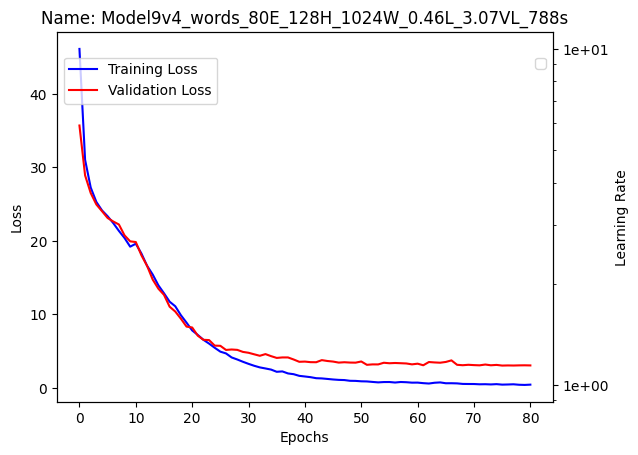

1/1 [==============================] - 1s 727ms/step


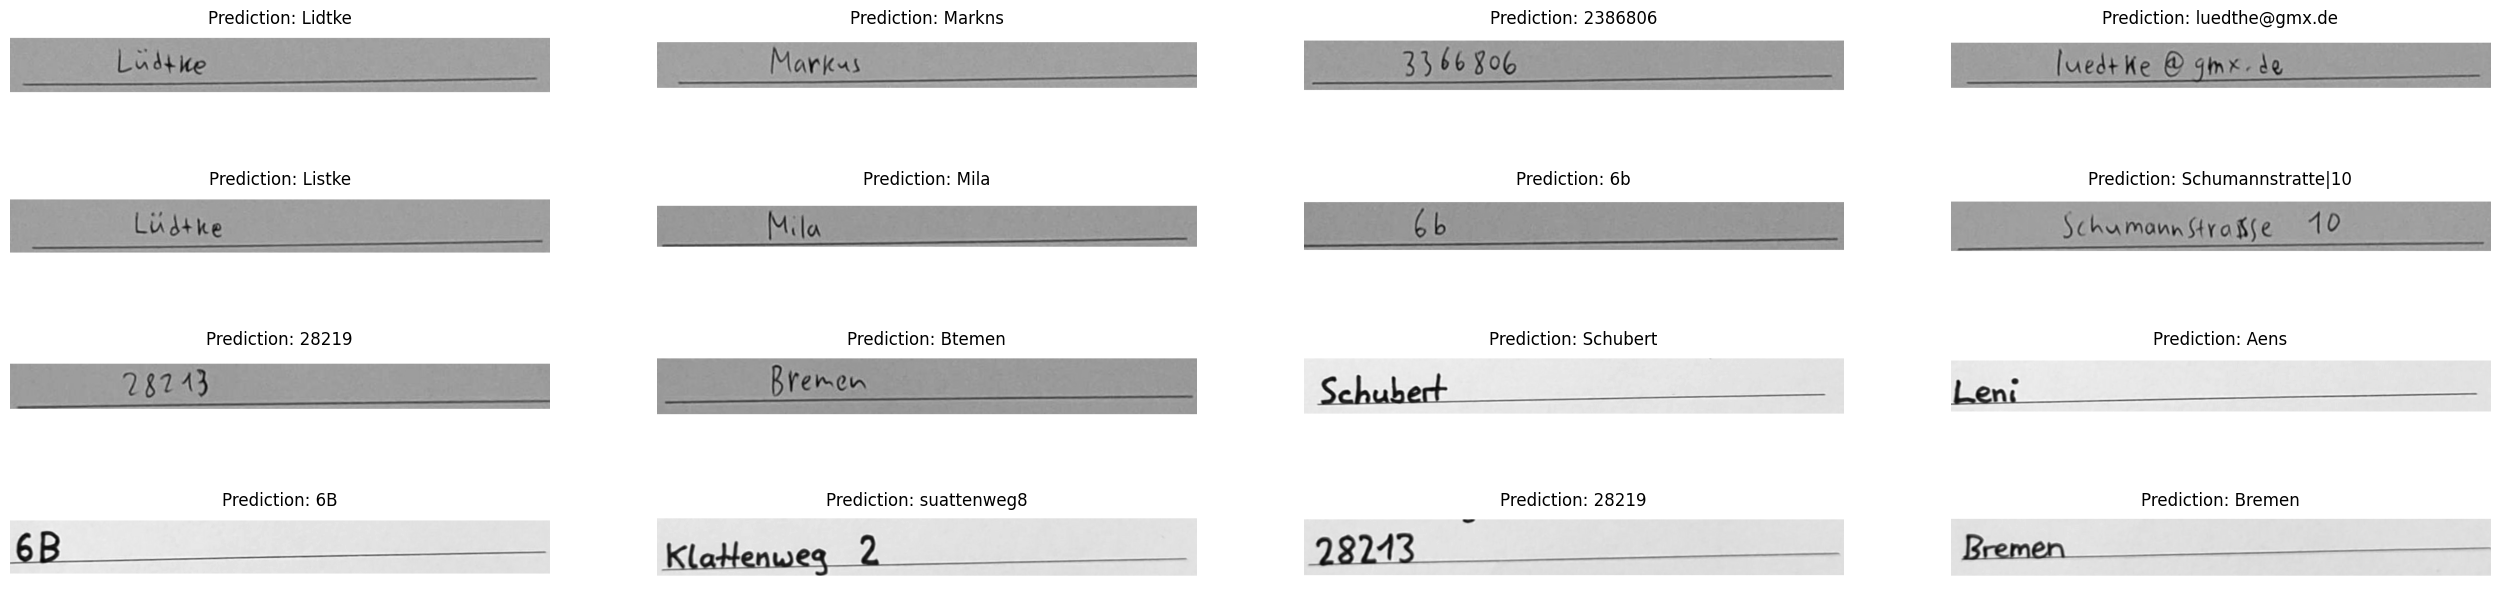

In [24]:
""" Creates a new plot name based on existing names.

This function generates a new plot name by appending a version number to the given model name.
The version number is determined based on existing plot names in the directory.

Args:
    model_name (str): The base model name.
    names (list): A list of existing plot names.
    format (str): The format string for the plot name.

Returns:
    str: The new plot name.
"""
if not os.path.exists(TEST_RESULT_DIR_NAME):
            create_dir(TEST_RESULT_DIR_NAME)
files_with_model_name = [file for file in os.listdir(TEST_RESULT_DIR_NAME) if MODEL_NAME in file]
metrics = history.history

NAME = "{name}_{epoch}E_{height}H_{width}W_{loss}L_{val_loss}VL_{time}s".format(
    name=MODEL_NAME, epoch=history.epoch[-1], height=IMAGE_HEIGHT, width=IMAGE_WIDTH,
    loss=round(metrics['loss'][-1],2), val_loss=round(metrics['val_loss'][-1], 2), time=round(total_duration))

if not files_with_model_name:
    if SAVE_HISTORY:
        plot_history(history, NAME, TEST_RESULT_DIR_NAME, True)
        plot_evaluation(NAME, TEST_RESULT_DIR_NAME, True)
else:
    new_name = create_new_plot_name(MODEL_NAME,files_with_model_name, NAME)
    plot_history(history, new_name, TEST_RESULT_DIR_NAME, True)
    plot_evaluation(new_name, TEST_RESULT_DIR_NAME, True)

# Save the Model

In [27]:
# Saves the model after training if MODEL_SAVE = True
if MODEL_SAVE:
    if not os.path.exists(MODEL_DIR_NAME):
        create_dir(MODEL_DIR_NAME)
    model_path = os.path.join(MODEL_DIR_NAME, "{model_name}".format(model_name=MODEL_NAME))
    model.save(model_path)
    model.save_weights(os.path.join(model_path, f"{MODEL_NAME}{weights_keras_string}"), overwrite=True, save_format=None, options=None)
    json_string = model.to_json()

    with open(os.path.join(model_path, f"{MODEL_NAME}.json"),'w') as f:
        f.write(json_string)

    data_to_save = (load_transfer_data.max_len, load_transfer_data.characters)
    import pickle
    with open(os.path.join(model_path, "handwriting_chars.pkl"), 'wb') as file:
        pickle.dump(data_to_save, file)

INFO:tensorflow:Assets written to: models/keras/Model9v4_words/assets


INFO:tensorflow:Assets written to: models/keras/Model9v4_words/assets
